# System Setup

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
from functions import *
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from scipy.spatial.distance import cdist

# Calculate the Interface Residues

In [2]:
# load data from the pdb file with mdtraj module and save it as pandas df
path2AB = '../01_receptor_prep/hmx.B99990001.pdb'
AB = md.load(path2AB)
table,_ = AB.topology.to_dataframe()

# Get atomnumber residues and atomic coordinates for both proteins
A_num = table.query('chainID == 0').shape[0]
B_num = table.query('chainID == 1').shape[0]
A_resid = table.query('chainID == 0').resSeq.unique()
B_resid = table.query('chainID == 1').resSeq.unique()
A_xyz = AB.xyz[:,:A_num][0]
B_xyz = AB.xyz[:,-B_num:][0]

# Calculating the interface residue
cutoff = 0.5 
# boolean pair matrix specifying contact or not with 1 or 0 at the respective matrix element
bool_iatoms = (cdist(A_xyz,B_xyz) < cutoff).astype(int)
# get the indices of interface atoms with np.where() and only keep the unique ones
A_iatoms, B_iatoms = np.where(bool_iatoms == 1)
A_iatoms = np.unique(A_iatoms)+1
B_iatoms = np.unique(B_iatoms)+A_num

# locate the interface atoms in the data frame and save the unique residues as interface residues
A_ires = table.loc[A_iatoms,:].resSeq.unique()
B_ires = table.loc[B_iatoms,:].resSeq.unique()

# Set User Specifications

In [5]:
# full control over which repititions to include via list, and same for residue IDs
reps = [1,2]
L_ids = ['0156', '1258']

# path to file containing total Binding free Energy
AL_gbsa_path = '3hmx_{}/AL_output_{}.dat'
BL_gbsa_path = '3hmx_{}/BL_output_{}.dat'

# path to file containing residue wise energy decomposition
AL_decomp_path = '3hmx_{}/AL_decomp_{}.csv'
BL_decomp_path = '3hmx_{}/BL_decomp_{}.csv'

# Calculate the total Free Binding Energies per Compound  and  Run

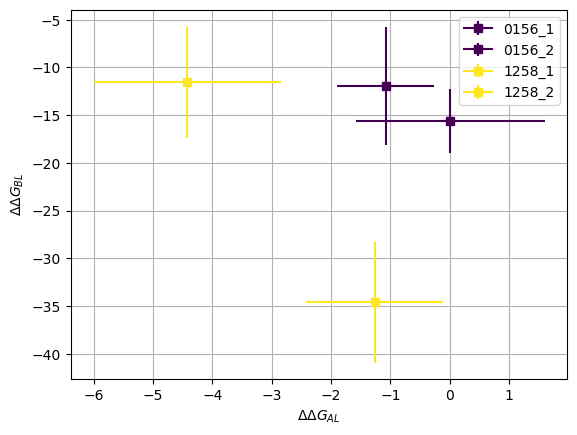

In [8]:
# Define color space depending on the number of compounds present
colors = viridis(np.linspace(0,1,len(L_ids)))

# iterate over compounds and repetitions
for i, L_id in enumerate(L_ids):
    for rep in reps:

        # read the avg dG, its standard deviation and its standard error
        AL_dG, AL_sdG, AL_seG = read_output(AL_gbsa_path.format(L_id,rep),gbsa_pattern)
        BL_dG, BL_sdG, BL_seG = read_output(BL_gbsa_path.format(L_id,rep),gbsa_pattern)
        # plot error bar diagram from the metrics above, color corresponds to ligand ID
        plt.errorbar(x=AL_dG, xerr=AL_sdG, y=BL_dG, yerr=BL_sdG, marker='s', label=L_id+'_'+str(rep), c=colors[i])

# Plot the figure and chose cooler axis labels
plt.xlabel(r'$\Delta \Delta G_{AL}$')
plt.ylabel(r'$\Delta \Delta G_{BL}$')
plt.legend()
plt.grid()
plt.savefig('dGAvsdGB.png', dpi=480)
plt.show()

# Inspect Residue-Wise Contributions to Binding Free Energies

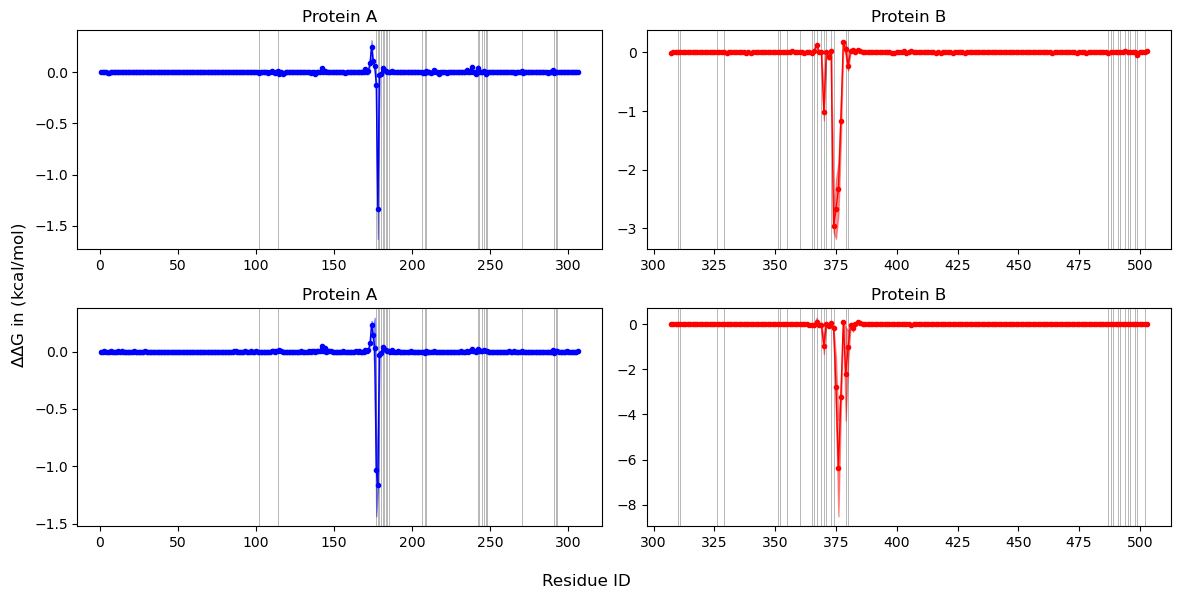

In [9]:
# Instantiate Figure object from subplots; one column for each protein and one row per ligand
fig, axs = plt.subplots(len(L_ids),2,figsize=(12,3*len(L_ids)))

# iterate over ligand ids
for i, L_id in enumerate(L_ids):

    # instantiate empty lists to hold the residuewise energy decomposition for each run
    AL_dG_decomp = []
    BL_dG_decomp = []
    
    # fill said lists from the files
    for rep in reps:
        AL_dG_decomp.append(pd.read_csv(AL_decomp_path.format(L_id,rep),skiprows=8,header=None)[17].values[:-1])
        BL_dG_decomp.append(pd.read_csv(BL_decomp_path.format(L_id,rep),skiprows=8,header=None)[17].values[:-1])
    
    # make the list into an array,calculate averages and standard deviations per residues
    AL_dG_decomp = np.array(AL_dG_decomp)
    BL_dG_decomp = np.array(BL_dG_decomp)
    AL_avg = np.mean(AL_dG_decomp, axis=0)
    BL_avg = np.mean(BL_dG_decomp, axis=0)
    AL_std = np.std(AL_dG_decomp, axis=0)
    BL_std = np.std(BL_dG_decomp, axis=0)

    # plot the interface residues on the x axis as vertical lines for protein A and B
    for res in A_ires:
        axs[i,0].axvline(res, c='black', alpha=0.4, lw=0.5)
    for res in B_ires:
        axs[i,1].axvline(res, c='black', alpha=0.4, lw=0.5)

    # plot the energy values for each residue of chain A and B, greater zero means, the residue is unfavourable
    axs[i,0].plot(A_resid, AL_avg, color='b', lw=1, marker='.')
    axs[i,1].plot(B_resid, BL_avg, color='r', lw=1, marker='.')
    axs[i,0].fill_between(A_resid, y1=AL_avg-AL_std,y2=AL_avg+AL_std, alpha=0.4,color='b')
    axs[i,1].fill_between(B_resid, y1=BL_avg-BL_std,y2=BL_avg+BL_std, alpha=0.4,color='r')
    # Specify title
    axs[i,0].set_title('Protein A')        
    axs[i,1].set_title('Protein B')

# more figure specifications
fig.supxlabel('Residue ID')
fig.supylabel('$\Delta\Delta$G in (kcal/mol)')
plt.tight_layout()
plt.savefig('FE_ResidueDecomp.png', dpi=480)
plt.show()

# Closer Analysis of the Trajectory 
### Look Individual Compounds and Find Optimisation Potential with Respect to Favourable and Unfavourable Residues

In [6]:
# Initialise Lists to hold intermediate results
negG_res = []
posG_res = []
AL_dG_decomp = []
BL_dG_decomp = []

# choose the Ligand that might be of interest
L_id = '0156'

# load the trajectory as a pytraj object from the specified filepath, change this to the appropriate file
nc = '../05_mdsimulation/_sim/3hmx_{}/prod_center_1.nc'.format(L_id)
traj = pt.load(nc, top='../05_mdsimulation/_sim/3hmx_{}/3hmx_{}.prmtop'.format(L_id,L_id))
# align the trajectory to ease visual inspection via nglview
traj = pt.superpose(traj)
# create view, via nglview and clear the view
view = nv.show_pytraj(traj)
view.clear()        
# Add chainA, chainB and the ligand molecule as cartoon/ballnstick representation
view.add_cartoon(selection=":A",opacity=1,color="blue")
view.add_cartoon(selection=":B",opacity=1,color="red")
view.add_ball_and_stick(selection=":C and not hydrogen",opacity=1,aspectRatio=2,radiusSegments=10)

# read in the MMPBSA decomposition as in the jupyter cell above
for rep in reps:
    AL_dG_decomp.append(pd.read_csv(AL_decomp_path.format(L_id,rep),skiprows=8,header=None)[17].values[:-1])
    BL_dG_decomp.append(pd.read_csv(BL_decomp_path.format(L_id,rep),skiprows=8,header=None)[17].values[:-1])

# calculate the average dG values from all the MD trajectories available for ChainA and ChainB
AL_dG_decomp = np.array(AL_dG_decomp)
BL_dG_decomp = np.array(BL_dG_decomp)
AL_avg = np.mean(AL_dG_decomp, axis=0)
BL_avg = np.mean(BL_dG_decomp, axis=0)

# specify boolean filters for interface and positive and negative residue-dG-values (fav/unfav) of Chain A
ires_filter = np.isin(A_resid,A_ires).astype(int)
negG_filter = (AL_avg < 0)
posG_filter = (AL_avg >= 0)
# multiply the filters ('and' operation) and filter the residues of Chain A for being pos/neg and interfacial)
negG_res.extend(A_resid[(negG_filter * ires_filter).astype(bool)])
posG_res.extend(A_resid[(posG_filter * ires_filter).astype(bool)])

# specify boolean filters for interface and positive and negative residue-dG-values (fav/unfav) of Chain A
ires_filter = np.isin(B_resid,B_ires).astype(int)
negG_filter = (BL_avg < 0)
posG_filter = (BL_avg >= 0)
# multiply the filters ('and' operation) and filter the residues of Chain B for being pos/neg and interfacial)
negG_res.extend(B_resid[(negG_filter * ires_filter).astype(bool)])
posG_res.extend(B_resid[(posG_filter * ires_filter).astype(bool)])

# add the positively and negatively contributing residues to the view as ballnstick representation
for res in negG_res:
    view.add_ball_and_stick(selection=str(res),color='white')
for res in posG_res:
    view.add_ball_and_stick(selection=str(res),color='black')
# present the view! 
view

NGLWidget(max_frame=100)